Images generated by GANs..
<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:820/1*9RZd1Gk5kMgM0GymWP8YGg.png" alt="controlnet-structure"><br>
</p>

#ControlNet
What is ControlNet ?\
Control Net is one of the recent deep learning architectures for image generation. Image generation models up till now had the ability to make images out of text prompts. \
ControlNet alows to us to use image to image generation and many more formats !!

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) by Lvmin Zhang and Maneesh Agrawala. 

Training a ControlNet:

1. Cloning the pre-trained parameters of a Diffusion model, such as Stable Diffusion's latent UNet, (referred to as “trainable copy”) while also maintaining the pre-trained parameters separately (”locked copy”). It is done so that the locked parameter copy can preserve the vast knowledge learned from a large dataset, whereas the trainable copy is employed to learn task-specific aspects. 

2. The trainable and locked copies of the parameters are connected via “zero convolution” layers  which are optimized as a part of the ControlNet framework. This is a training trick to preserve the semantics already learned by frozen model as the new conditions are trained.


UNet:
<p align="center">
    <img src="https://images.velog.io/images/kimkj38/post/10a66515-e857-445e-af04-a31aa20c4cbd/image.png" alt="controlnet-structure"><br>
    
</p>

Model Architecture:
<p align="center">
    <img src="https://github.com/lllyasviel/ControlNet/raw/main/github_page/sd.png" alt="controlnet-structure"><br>
    <em>The diagram is taken from <a href=https://github.com/lllyasviel/ControlNet/blob/main/github_page/sd.png>here</a>.</em>
</p>

##Installing Dependencies

In [ ]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.2 MB/s eta 0:00:00


In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
from diffusers import ControlNetModel
import torch



###Load Images
We will use a well known painting and change the face..

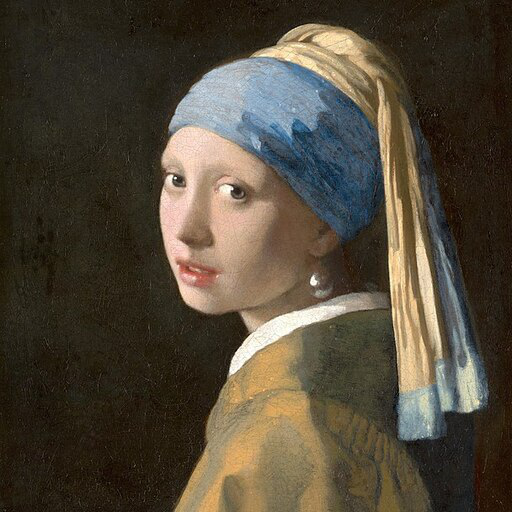

In [ ]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

We convert the image to a canny image ie essentially just an edge detection..

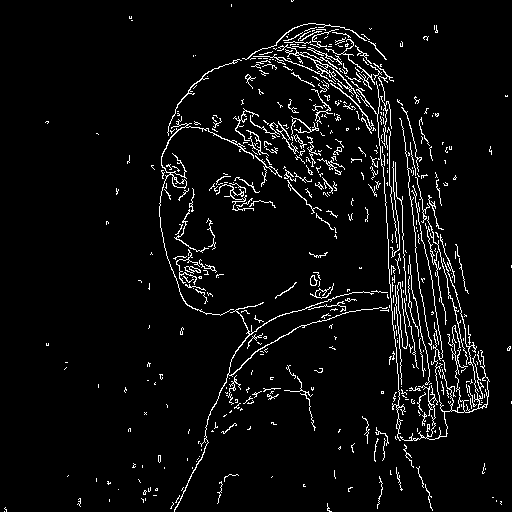

In [ ]:
#Convert image from normal rgb to canny image ie. essentially edge detection
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

###Importing pretrained ControlNet pipeline 
The controlnet has more than one pipelines. The one we are using is used for loading and converting Canny Images.

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
from diffusers import UniPCMultistepScheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

##Generating Images

In [ ]:
def image_grid(imgs, rows, cols):
  #Generates a grid of the generated images
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


We are going to convert the images to Anime style image therefore changing the style of the painting and the second prompt we change the face to Taylor Swift..

Prompt 1: anime, best quality, extremely detailed

Prompt 2: taylor swift, best quality, extremely detailed


  0%|          | 0/20 [00:00<?, ?it/s]

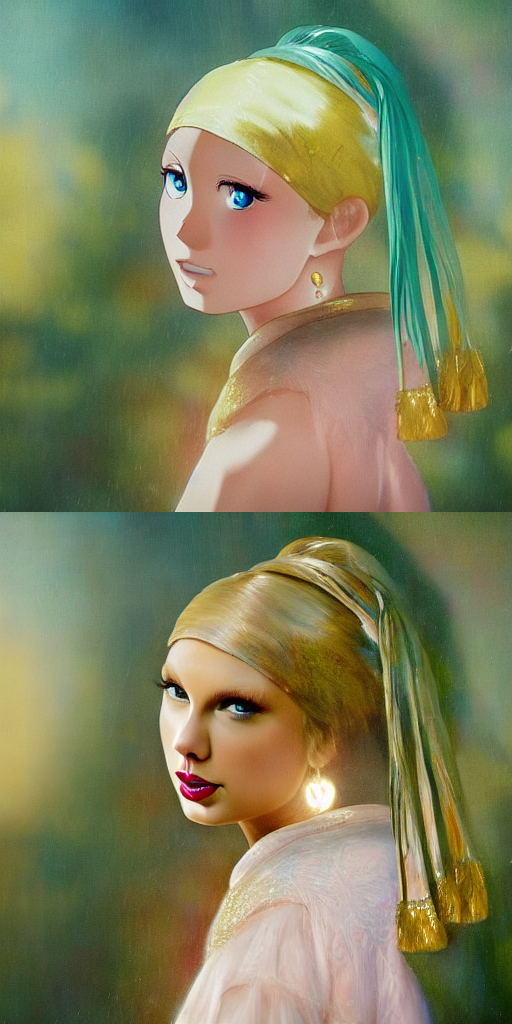

In [ ]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["anime","taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images,2,1)